In [28]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
import time
from torch_geometric.data import Dataset, Data
import matplotlib.pyplot as plt
import os

In [29]:
# Parametri di clustering
CLUSTER_PARAMS = dict(
    charge_threshold=750,
    min_consecutive_strips=2,
    max_gap=2,
    max_cluster_size=15,
    max_internal_gap=2
)

def cluster_strips_with_charges(event, params):
    clusters = []
    charges = []
    current_cluster = []
    current_charges = []
    previous_index = None
    for strip_index, charge in enumerate(event):
        if charge >= params['charge_threshold']:
            if previous_index is not None and strip_index - previous_index - 1 >= params['max_gap']:
                if params['min_consecutive_strips'] <= len(current_cluster) < params['max_cluster_size']:
                    n_gaps = (max(current_cluster) - min(current_cluster) + 1) - len(current_cluster)
                    if n_gaps <= params['max_internal_gap']:
                        clusters.append(current_cluster)
                        charges.append(current_charges)
                current_cluster = []
                current_charges = []
            current_cluster.append(strip_index)
            current_charges.append(charge)
            previous_index = strip_index
        else:
            continue
    # Chiudi eventuale cluster rimasto
    if params['min_consecutive_strips'] <= len(current_cluster) < params['max_cluster_size']:
        n_gaps = (max(current_cluster) - min(current_cluster) + 1) - len(current_cluster)
        if n_gaps <= params['max_internal_gap']:
            clusters.append(current_cluster)
            charges.append(current_charges)
    return clusters, charges

In [ ]:
# Carica i dati
x_events = np.load('data/2/test_x.npy', allow_pickle=True)
y_events = np.load('data/2/test_y.npy', allow_pickle=True)

def assign_labels(event, params):
    labels = np.zeros(len(event), dtype=int)
    clusters, _ = cluster_strips_with_charges(event, params)
    for i, cluster in enumerate(clusters):
        for idx in range(min(cluster), max(cluster) + 1):
            labels[idx] = 1
    return labels, len(clusters)

# Esempio: genera labels per tutti gli eventi X e Y e stampa il numero di cluster trovati
x_labels = []
y_labels = []
n_x_clusters = 0
n_y_clusters = 0
max_label = 0
for i in range(len(x_events)):
    
    x_label_temp, n_x_clusters_temp = assign_labels(x_events[i], CLUSTER_PARAMS)
    x_labels.append(x_label_temp)
    n_x_clusters+=(n_x_clusters_temp)

    y_labels_temp, n_y_clusters_temp = assign_labels(y_events[i], CLUSTER_PARAMS)
    y_labels.append(y_labels_temp)
    n_y_clusters+=(n_y_clusters_temp)

print(f"Numero di cluster trovati in X: {n_x_clusters}")
print(f"Numero di cluster trovati in Y: {n_y_clusters}")

Numero di cluster trovati in X: 908
Numero di cluster trovati in Y: 3047
Numero massimo di label: 1


In [31]:
# Unisci gli eventi x e y per formare all_events e all_labels
all_events = np.concatenate([x_events, y_events], axis=0)
all_labels = np.concatenate([x_labels, y_labels], axis=0)

In [32]:
# Crea direttamente una lista di Data per tutti gli eventi
def events_to_graphs(events, labels):
    data_list = []
    for event, label in zip(events, labels):
        event = np.array(event, dtype=np.float32)
        label = np.array(label, dtype=np.int64)
        x = torch.tensor(event, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(label, dtype=torch.long)
        N = x.shape[0]
        edge_index = torch.tensor(
            [[i, i+1] for i in range(N-1)] + [[i+1, i] for i in range(N-1)],
            dtype=torch.long
        ).t().contiguous()
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

# Unisci eventi e label in una lista di tuple
all_data = list(zip(all_events, all_labels))

# Split: 70% train, 15% val, 15% test
train_data, temp_data = train_test_split(all_data, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# Estrai eventi e label per ogni split
train_events, train_labels = zip(*train_data)
val_events, val_labels = zip(*val_data)
test_events, test_labels = zip(*test_data)

# Crea i dataset come liste di Data
train_graphs = events_to_graphs(train_events, train_labels)
val_graphs = events_to_graphs(val_events, val_labels)
test_graphs = events_to_graphs(test_events, test_labels)

# DataLoader PyG
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)

In [ ]:
# Modello GNN per la segmentazione strip-wise con dropout e blocchi ripetibili
class StripGCN(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32, num_classes=3, num_layers=3, dropout=0.3):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        # Primo layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns.append(BatchNorm(hidden_channels))
        # Layer intermedi
        for _ in range(num_layers-1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(BatchNorm(hidden_channels))
        # Testa finale: MLP (non convoluzionale)
        self.head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, num_classes)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = F.relu(bn(x))
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.head(x)
        return x

# Esempio di istanziazione del modello
# Puoi cambiare num_layers e dropout a piacere
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = StripGCN(in_channels=1, hidden_channels=32, num_classes= 2, num_layers=6, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

Using device: cpu


In [34]:
def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

def load_model(model, optimizer, checkpoint_path, load_checkpoint=True):
    if load_checkpoint and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Checkpoint loaded from {checkpoint_path}")
    else:
        print("No checkpoint loaded.")
    return model, optimizer

In [35]:
# Parametro per decidere se caricare il checkpoint
LOAD_CHECKPOINT = False
checkpoint_path = "gnn_model/checkpoint.pt"
model_path = "gnn_model/model.pt"

model, optimizer = load_model(model, optimizer, checkpoint_path, load_checkpoint=LOAD_CHECKPOINT)

No checkpoint loaded.


In [36]:
# Training loop con salvataggio checkpoint
epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    total_loss = 0
    total_train_samples = 0
    for batch in train_loader:
        batch = batch.to(device)
        out = model(batch)  # [num_nodes, num_classes]
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item() * batch.y.size(0)
        total_train_samples += batch.y.size(0)
    avg_train_loss = total_loss / total_train_samples
    elapsed = time.time() - start_time

    # Validation loss
    model.eval()
    val_loss = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item() * batch.y.size(0)
            total_val_samples += batch.y.size(0)
    avg_val_loss = val_loss / total_val_samples
    print(f"Epoch {epoch+1}/{epochs} - Train loss: {avg_train_loss:.4E} - Val loss: {avg_val_loss:.4E} - Time: {elapsed:.2f}s")
    # Salva checkpoint ad ogni epoca
    save_checkpoint(model, optimizer, epoch, checkpoint_path)

# Salva il modello finale
save_model(model, model_path)
print(f"Modello finale salvato in {model_path}")

# Test accuracy (pixel-wise)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += batch.y.numel()
print(f"Test accuracy (strip-wise): {correct/total:.2%}")

KeyboardInterrupt: 

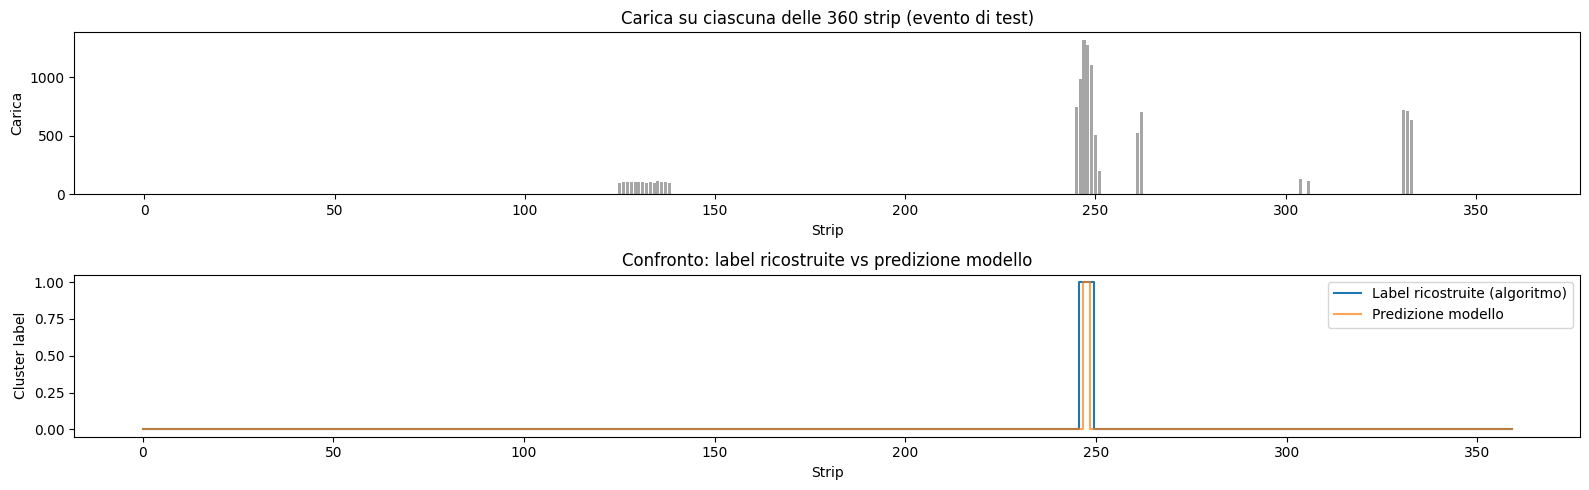

In [ ]:
# Salva i primi 20 plot dal test_loader
os.makedirs("image", exist_ok=True)
model.eval()
count = 0
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        for i in range(batch.num_graphs):
            data = batch[i]
            charges = data.x.cpu().numpy().flatten()
            labels_true = data.y.cpu().numpy()
            pred = model(data)
            pred_labels = pred.argmax(dim=1).cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.subplot(2, 1, 1)
            plt.bar(np.arange(len(charges)), charges, color='gray', alpha=0.7)
            plt.title('Carica su ciascuna delle 360 strip (evento di test)')
            plt.xlabel('Strip')
            plt.ylabel('Carica')
            plt.subplot(2, 1, 2)
            plt.plot(labels_true, label='Label ricostruite (algoritmo)', drawstyle='steps-mid')
            plt.plot(pred_labels, label='Predizione modello', drawstyle='steps-mid', alpha=0.7)
            plt.xlabel('Strip')
            plt.ylabel('Cluster label')
            plt.legend()
            plt.title('Confronto: label ricostruite vs predizione modello')
            plt.tight_layout()
            plt.savefig(f"image/test_example_{count+1}.png")
            plt.close()
            count += 1
            if count >= 20:
                break
        if count >= 20:
            break
print("Salvati i primi 20 plot in 'image/'")